# Sementic segmentation for Video

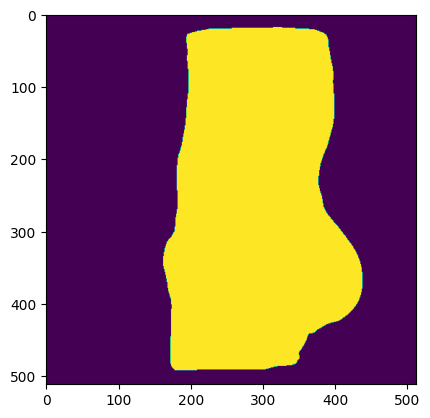

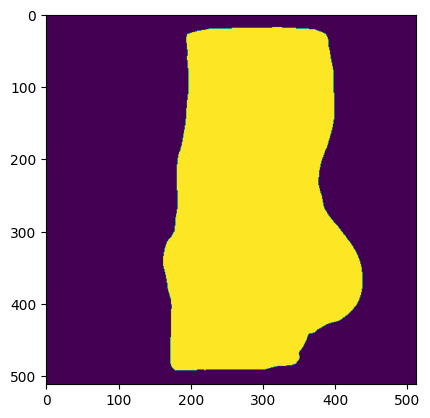

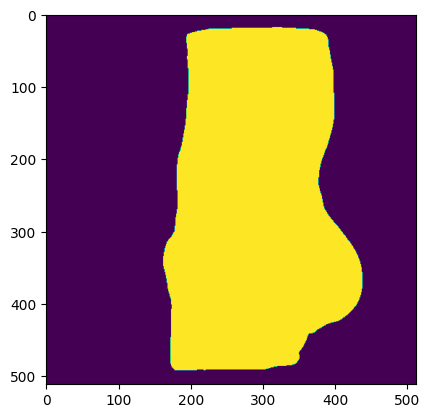

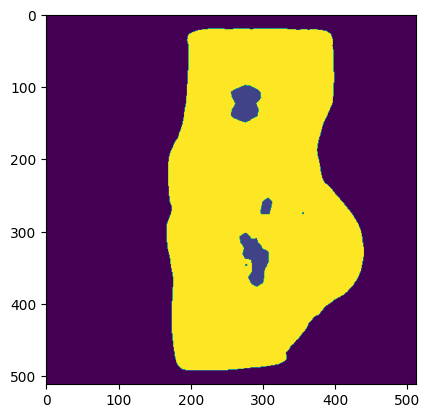

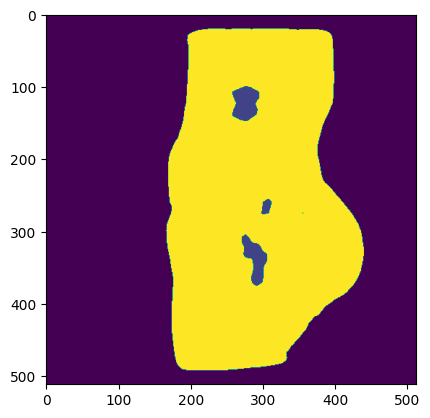

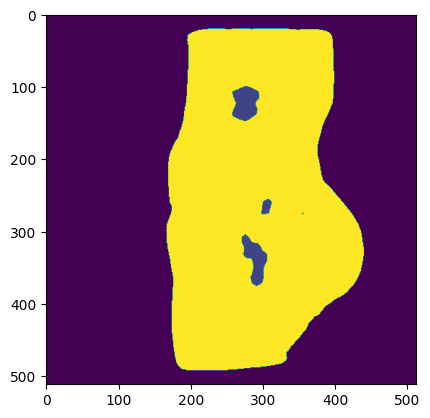

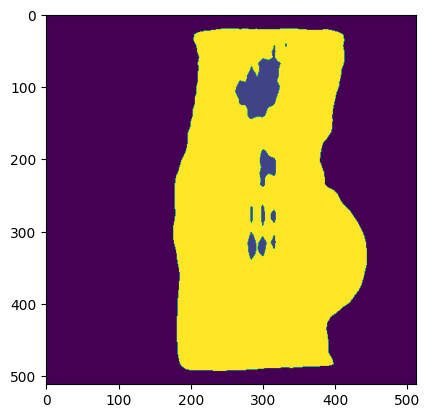

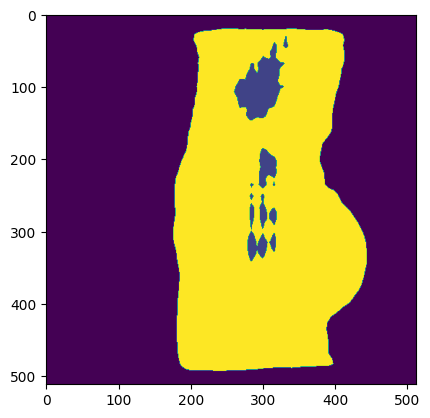

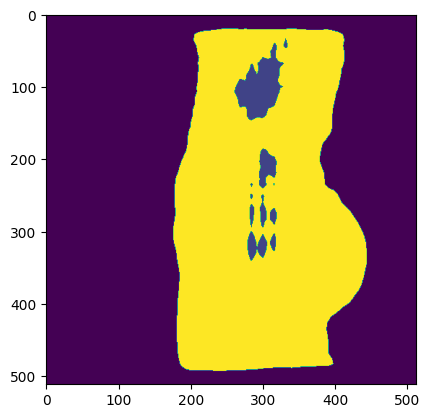

KeyboardInterrupt: 

<Figure size 640x480 with 0 Axes>

In [13]:
import cv2
import numpy as np
import torch
import torchvision.transforms as transforms
import torchvision.models as models
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw

# semantic segmentation pre-trained model 불러오기
model = models.segmentation.deeplabv3_resnet101(pretrained=True)
model.eval()

# 비디오 데이터 읽어들이기
cap = cv2.VideoCapture('Girlwithacat.mp4')
while True:
    ret, frame = cap.read()
    if not ret:
        break

    # 이미지 전처리
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((512, 512)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    input_tensor = transform(frame)
    input_tensor = input_tensor.unsqueeze(0)

    # semantic segmentation 적용
    model.eval()
    with torch.no_grad():
            output = model(input_tensor)['out'][0]

    output = output.argmax(0).byte().cpu().numpy()
    output_image = Image.fromarray(output)
    plt.imshow(output_image)
    plt.show(block=False)
    plt.pause(0.1)
    plt.clf()
#         result = model(input_tensor)['out']
#         result = torch.argmax(result.squeeze(), dim=0)

#     # 결과 시각화
#     result = np.array(result, dtype=np.uint8)
#     result = cv2.resize(result, (frame.shape[1], frame.shape[0])) 
#     result = cv2.applyColorMap(result, cv2.COLORMAP_JET)
#     output = cv2.addWeighted(frame, 0.5, result, 0.5, 0)
#     output = cv2.cvtColor(output, cv2.COLOR_BGR2RGB)  # matplotlib은 RGB 색상 모델을 사용하므로 BGR에서 RGB로 변경
#     plt.imshow(output)
#     plt.show(block=False)
#     plt.pause(0.1)
#     plt.clf()

# cap.release()
# cv2.destroyAllWindows()

# instance segmentation for Video

In [12]:
import cv2
import numpy as np
import torch
import torchvision.transforms as transforms
import torchvision.models as models
import torchvision.ops as ops
import matplotlib.pyplot as plt

from PIL import Image, ImageDraw
# instance segmentation pre-trained model 불러오기
model = models.detection.maskrcnn_resnet50_fpn(pretrained=True)
model.eval()

# 비디오 데이터 읽어들이기
cap = cv2.VideoCapture('Girlwithacat.mp4')

# 비디오 저장을 위한 설정
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter('output.mp4', fourcc, 30, (int(cap.get(3)), int(cap.get(4))))

while True:
    ret, frame = cap.read()
    if not ret:
        break

    # 이미지 전처리
    transform = transforms.Compose([
        transforms.Resize((512, 512)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    
    transform_img = transforms.Compose([
        
        transforms.ToPILImage(),
        transforms.Resize((512, 512))
    ])
    
    im = transform_img(frame)

    image_tensor = transform(im)

    model.eval()
    with torch.no_grad():
        output = model([image_tensor])[0]
        
    masks = output['masks'].squeeze().cpu().numpy()
    labels = output['labels'].cpu().numpy()
    scores = output['scores'].cpu().numpy()
    boxes = output['boxes'].cpu().numpy()
    
    mask_image = np.zeros((im.height, im.width), dtype=np.uint8)
    for mask, label, score, box in zip(masks, labels, scores, boxes):
        if score > 0.2:
            mask = (mask > 0.5).astype(np.uint8)
            mask = Image.fromarray(mask)
            mask = mask.resize((im.width, im.height), resample=Image.BILINEAR)
            mask = np.array(mask)
            mask_image += mask
            draw = ImageDraw.Draw(im)
            draw.rectangle(box.tolist(), outline='red')
            draw.text((box[0], box[1]), str(label), fill='red')

    mask_image = Image.fromarray(mask_image * 255)
    mask_image.putalpha(128)
    im.paste(mask_image, (0, 0), mask_image)
    im.show()


KeyboardInterrupt: 